### NVIDIA Information

In [ ]:
!nvidia-smi

Mon Nov 28 07:18:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   26C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 0. Import Libraries

In [ ]:
import os
import json

from google.colab import drive
from PIL import Image
from matplotlib import pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

### 1. Connect to Google Drive

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/RubClassifier"
print("云盘路径：" + path)

### 2. RubDataset Class

In [ ]:
class RubDataset(Dataset):
    def __init__(self, json_path, transform):
        with open(json_path, 'r') as f:
            self.dataset = json.load(f)
        self.transform = transform

    def __getitem__(self, idx):
        item_path = path + "/" + self.dataset[idx]['path']
        image = Image.open(item_path)
        image = self.transform(image)
        label = self.dataset[idx]['label']
        label = int(label)
        return image, label

    def __len__(self):
        return len(self.dataset)

### 3. ResNet Class

In [ ]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.prior = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                      kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.downsample = downsample

    def forward(self, x):
        shortcut = x
        # 层间连接为虚线连接，借助下采样实现规格统一
        if self.downsample is not None:
            shortcut = self.downsample(x)
        out = self.prior(x)
        out += shortcut
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.prior = nn.Sequential(
            # First Layer
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            # Second Layer
            nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                      kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            # Third Layer
            nn.Conv2d(in_channels=out_channel, out_channels=out_channel * self.expansion,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channel * self.expansion)
        )
        self.downsample = downsample

    def forward(self, x):
        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)
        out = self.prior(x)
        out += shortcut
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, blocks_num, num_classes=1000, include_top=True):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64
        self.pre = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.in_channel,
                      kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channel),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)

        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, blocks_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion)
            )
        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, blocks_num):
            layers.append(block(self.in_channel, channel))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pre(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
        return x


def resnet18(num_classes=1000, include_top=True):
    return ResNet(ResidualBlock, [2, 2, 2, 2],
                  num_classes=num_classes, include_top=include_top)


def resnet34(num_classes=1000, include_top=True):
    return ResNet(ResidualBlock, [3, 4, 6, 3],
                  num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes, include_top=include_top)

### 4. Set Parameters

In [ ]:
# Path Variables
train_path = path + "/RubbishClassification/train.json"
val_path = path + "/RubbishClassification/val.json"
model_weight_path = path + "/ResNetModels/ResNet68.pth"
save_path = path + "/ResNetModels"
# Training Parameters
learning_rate = 1e-4
batch_size = 32
epochs = 80
# Train Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training device: {}".format(device))

### 5. Set Transforms

In [ ]:
# PyTorch Transforms
transform4train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform4test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Albumentations Transforms
albtrans4train = A.Compose([
    A.Resize(height=256, width=256),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.IAAAdditiveGaussianNoise(),  # 将高斯噪声添加到输入图像
        A.GaussNoise(),  # 将高斯噪声应用于输入图像
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),  # 使用随机大小的内核将运动模糊应用于输入图像
        A.MedianBlur(blur_limit=3, p=0.1),  # 中值滤波
        A.Blur(blur_limit=3, p=0.1),  # 使用随机大小的内核模糊输入图像
    ], p=0.2),
    # 随机应用仿射变换：平移，缩放和旋转输入
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    # 随机明亮对比度
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
])
albtrans4test = A.Compose([
    A.Resize(height=256, width=256),
    A.CenterCrop(height=224, width=224),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensorV2()
])

### 6. Set Dataset and DataLoader

In [ ]:
# Set Train Dataset and Test Dataset
train_data = RubDataset(train_path, transform4train)
test_data = RubDataset(val_path, transform4test)
# Set Train DataLoader and Test DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size,
                          shuffle=True, drop_last=False, num_workers=4)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size,
                         shuffle=False, drop_last=False, num_workers=4)
# Print Information about Datasets
train_data_size = len(train_data)
test_data_size = len(test_data)
print("训练数据集的大小为: {}".format(train_data_size))
print("测试数据集的大小为: {}".format(test_data_size))

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


训练数据集的大小为: 4723
测试数据集的大小为: 3303


### 7. Set ResNet

In [ ]:
# ResNet34模型
net = resnet34()
# ResNet50模型
# net = resnet50()
# 加载预训练ResNet网络模型（包含参数）
# net = torch.load(model_weight_path)
# 加载预训练ResNet网络权重参数
net.load_state_dict(torch.load(model_weight_path), strict=False)
# 根据数据集种类（16类）改变全连接层
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 16)
# 网络模型根据设备进行转化
net = net.to(device)
# print("网络结构如下:")
# print(net)

### 8. Set Loss Function and Optimizer

In [ ]:
# Set Loss Function
loss_func = nn.CrossEntropyLoss()
loss_func = loss_func.to(device)
# Set Optimizer
optimizer_adam = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001)
optimizer_sgd = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
optimizer = optimizer_adam

### 9. Train and Test

In [ ]:
# 全部训练损失
train_loss_all = []
# 全部测试损失
test_loss_all = []
# 全部训练精度
train_acc_all = []
# 全部测试精度
test_acc_all = []

for i in range(epochs):
    print("第 {} 轮训练开始".format(i + 1))
    # 开始训练
    net.train()  # 设置网络为训练模式
    train_loss = 0  # 初始化训练损失
    train_acc = 0.0  # 初始化训练准确率
    train_num = 0  # 初始化训练数
    # 设置训练进度条
    train_bar = tqdm(train_loader)
    for step, data in enumerate(train_bar):
        # 获取数据
        img, target = data
        img = img.to(device)
        target = target.to(device)
        # 前馈
        train_output = net(img)
        loss = loss_func(train_output, target)
        train_output = torch.argmax(train_output, 1)
        # 后馈
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 计算 Loss 和 Accuracy
        train_loss += abs(loss.item()) * img.size(0)
        accuracy = torch.sum(train_output == target)
        train_acc += accuracy
        train_num += img.size(0)
    print("Train-Loss: {}, Train-Accuracy: {}".format(train_loss / train_num, train_acc / train_num))
    train_loss_all.append(train_loss / train_num)
    train_acc_all.append(train_acc.double().item() / train_num)
    # 开始测试
    net.eval()	# 设置网络为测试模式
    test_loss = 0	# 初始化测试损失
    test_acc = 0.0	# 初始化测试准确率
    test_num = 0	# 初始化测试数
    with torch.no_grad():
        # 设置训练进度条
        test_bar = tqdm(test_loader)
        for data in test_bar:
            # 加载数据
            img, target = data
            img = img.to(device)
            target = target.to(device)
			# 前馈
            test_output = net(img)
            loss = loss_func(test_output, target)
            test_output = torch.argmax(test_output, 1)
			# 计算 Loss 和 Accuracy
            test_loss += abs(loss.item()) * img.size(0)
            accuracy = torch.sum(test_output == target)
            test_acc += accuracy
            test_num += img.size(0)
        print("Test-Loss: {}, Test-Accuracy: {}".format(test_loss / test_num, test_acc / test_num))
        test_loss_all.append(test_loss / test_num)
        test_acc_all.append(test_acc.double().item() / test_num)

    # 保存模型
    torch.save(net, save_path + "/ResNet{}.pth".format(i + 1))
    print("模型已保存")

第 1 轮训练开始


100%|██████████| 148/148 [03:46<00:00,  1.53s/it]


Train-Loss: 0.7292468889825253, Train-Accuracy: 0.7531229853630066


100%|██████████| 104/104 [03:20<00:00,  1.93s/it]


Test-Loss: 1.4886448861539923, Test-Accuracy: 0.5855283141136169
模型已保存
第 2 轮训练开始


100%|██████████| 148/148 [00:18<00:00,  7.87it/s]


Train-Loss: 0.6900123249366328, Train-Accuracy: 0.769426167011261


100%|██████████| 104/104 [00:12<00:00,  8.00it/s]


Test-Loss: 1.500359539331684, Test-Accuracy: 0.5906751155853271
模型已保存
第 3 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.57it/s]


Train-Loss: 0.7150718502995324, Train-Accuracy: 0.7592631578445435


100%|██████████| 104/104 [00:13<00:00,  8.00it/s]


Test-Loss: 1.4486736483982465, Test-Accuracy: 0.5915834307670593
模型已保存
第 4 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.60it/s]


Train-Loss: 0.6658890209358526, Train-Accuracy: 0.7810713648796082


100%|██████████| 104/104 [00:12<00:00,  8.06it/s]


Test-Loss: 1.4719666023345344, Test-Accuracy: 0.6012715697288513
模型已保存
第 5 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.73it/s]


Train-Loss: 0.6567724030350518, Train-Accuracy: 0.7719669342041016


100%|██████████| 104/104 [00:12<00:00,  8.01it/s]


Test-Loss: 1.5166805066955549, Test-Accuracy: 0.5840145349502563
模型已保存
第 6 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.47it/s]


Train-Loss: 0.6682464930558392, Train-Accuracy: 0.7751429080963135


100%|██████████| 104/104 [00:12<00:00,  8.03it/s]


Test-Loss: 1.4471509111061118, Test-Accuracy: 0.6039963364601135
模型已保存
第 7 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.48it/s]


Train-Loss: 0.6734535052517373, Train-Accuracy: 0.7766250371932983


100%|██████████| 104/104 [00:12<00:00,  8.03it/s]


Test-Loss: 1.5717367100203141, Test-Accuracy: 0.5767484307289124
模型已保存
第 8 轮训练开始


100%|██████████| 148/148 [00:18<00:00,  7.95it/s]


Train-Loss: 0.6466612254894313, Train-Accuracy: 0.7800126671791077


100%|██████████| 104/104 [00:12<00:00,  8.07it/s]


Test-Loss: 1.5945053426128715, Test-Accuracy: 0.585225522518158
模型已保存
第 9 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.58it/s]


Train-Loss: 0.624568979580625, Train-Accuracy: 0.7865763306617737


100%|██████████| 104/104 [00:13<00:00,  7.95it/s]


Test-Loss: 1.461616758285347, Test-Accuracy: 0.5952164530754089
模型已保存
第 10 轮训练开始


100%|██████████| 148/148 [00:18<00:00,  7.89it/s]


Train-Loss: 0.6531482937475799, Train-Accuracy: 0.7810713648796082


100%|██████████| 104/104 [00:12<00:00,  8.03it/s]


Test-Loss: 1.5023394815134272, Test-Accuracy: 0.5955192446708679
模型已保存
第 11 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.72it/s]


Train-Loss: 0.6566066053517915, Train-Accuracy: 0.7798009514808655


100%|██████████| 104/104 [00:12<00:00,  8.02it/s]


Test-Loss: 1.5082644187353829, Test-Accuracy: 0.6067211627960205
模型已保存
第 12 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.36it/s]


Train-Loss: 0.6170261016897597, Train-Accuracy: 0.7973745465278625


100%|██████████| 104/104 [00:12<00:00,  8.01it/s]


Test-Loss: 1.471951974185351, Test-Accuracy: 0.5997577905654907
模型已保存
第 13 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.25it/s]


Train-Loss: 0.6282816892353731, Train-Accuracy: 0.785305917263031


100%|██████████| 104/104 [00:13<00:00,  8.00it/s]


Test-Loss: 1.550866639545532, Test-Accuracy: 0.5815925002098083
模型已保存
第 14 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.52it/s]


Train-Loss: 0.616032039642132, Train-Accuracy: 0.7961041331291199


100%|██████████| 104/104 [00:13<00:00,  7.98it/s]


Test-Loss: 1.5816214656671033, Test-Accuracy: 0.5840145349502563
模型已保存
第 15 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.40it/s]


Train-Loss: 0.5917019644279287, Train-Accuracy: 0.8016091585159302


100%|██████████| 104/104 [00:13<00:00,  7.96it/s]


Test-Loss: 1.4586499812131646, Test-Accuracy: 0.6046018600463867
模型已保存
第 16 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.62it/s]


Train-Loss: 0.5749156837137276, Train-Accuracy: 0.8096548914909363


100%|██████████| 104/104 [00:13<00:00,  7.96it/s]


Test-Loss: 1.531410828219231, Test-Accuracy: 0.5970330238342285
模型已保存
第 17 轮训练开始


100%|██████████| 148/148 [00:18<00:00,  7.84it/s]


Train-Loss: 0.5676409393807678, Train-Accuracy: 0.8054202795028687


100%|██████████| 104/104 [00:13<00:00,  7.92it/s]


Test-Loss: 1.5434208720552536, Test-Accuracy: 0.5812897086143494
模型已保存
第 18 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.55it/s]


Train-Loss: 0.5818946915815726, Train-Accuracy: 0.8003387451171875


100%|██████████| 104/104 [00:12<00:00,  8.07it/s]


Test-Loss: 1.4704838689442588, Test-Accuracy: 0.6000605225563049
模型已保存
第 19 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.42it/s]


Train-Loss: 0.5607193025862693, Train-Accuracy: 0.8096548914909363


100%|██████████| 104/104 [00:13<00:00,  7.99it/s]


Test-Loss: 1.5632939698874426, Test-Accuracy: 0.5921888947486877
模型已保存
第 20 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.55it/s]


Train-Loss: 0.542925153411144, Train-Accuracy: 0.817065417766571


100%|██████████| 104/104 [00:12<00:00,  8.03it/s]


Test-Loss: 1.7195642877267485, Test-Accuracy: 0.5821980237960815
模型已保存
第 21 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.65it/s]


Train-Loss: 0.5987287699456895, Train-Accuracy: 0.8026677966117859


100%|██████████| 104/104 [00:13<00:00,  7.97it/s]


Test-Loss: 1.465092215471617, Test-Accuracy: 0.6097487211227417
模型已保存
第 22 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.78it/s]


Train-Loss: 0.5563910513668274, Train-Accuracy: 0.8077492713928223


100%|██████████| 104/104 [00:12<00:00,  8.02it/s]


Test-Loss: 1.504431391679046, Test-Accuracy: 0.6052073836326599
模型已保存
第 23 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.50it/s]


Train-Loss: 0.5687307250681455, Train-Accuracy: 0.8060554265975952


100%|██████████| 104/104 [00:13<00:00,  7.97it/s]


Test-Loss: 1.5969923209898622, Test-Accuracy: 0.5785649418830872
模型已保存
第 24 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.14it/s]


Train-Loss: 0.5315297321447396, Train-Accuracy: 0.8257463574409485


100%|██████████| 104/104 [00:13<00:00,  7.92it/s]


Test-Loss: 1.5599585224778731, Test-Accuracy: 0.6091431975364685
模型已保存
第 25 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.60it/s]


Train-Loss: 0.5208000370172936, Train-Accuracy: 0.8299809098243713


100%|██████████| 104/104 [00:13<00:00,  7.92it/s]


Test-Loss: 1.5189700233117038, Test-Accuracy: 0.6088404655456543
模型已保存
第 26 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.59it/s]


Train-Loss: 0.5529732125279461, Train-Accuracy: 0.8162184953689575


100%|██████████| 104/104 [00:12<00:00,  8.03it/s]


Test-Loss: 1.516106961533549, Test-Accuracy: 0.6055101156234741
模型已保存
第 27 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.65it/s]


Train-Loss: 0.5042640163992866, Train-Accuracy: 0.8289222717285156


100%|██████████| 104/104 [00:13<00:00,  7.92it/s]


Test-Loss: 1.4932015395474874, Test-Accuracy: 0.6070238947868347
模型已保存
第 28 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.44it/s]


Train-Loss: 0.540681367023451, Train-Accuracy: 0.8206648230552673


100%|██████████| 104/104 [00:13<00:00,  7.95it/s]


Test-Loss: 1.4166354994466368, Test-Accuracy: 0.6260975003242493
模型已保存
第 29 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.48it/s]


Train-Loss: 0.4916318522376982, Train-Accuracy: 0.8259580731391907


100%|██████████| 104/104 [00:13<00:00,  7.93it/s]


Test-Loss: 1.5618609980384834, Test-Accuracy: 0.5812897086143494
模型已保存
第 30 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.69it/s]


Train-Loss: 0.5374692206586692, Train-Accuracy: 0.8185474872589111


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.5762879556141367, Test-Accuracy: 0.5967302322387695
模型已保存
第 31 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.69it/s]


Train-Loss: 0.49502907833468984, Train-Accuracy: 0.8327333927154541


100%|██████████| 104/104 [00:13<00:00,  7.89it/s]


Test-Loss: 1.4419340985564078, Test-Accuracy: 0.6188313364982605
模型已保存
第 32 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.15it/s]


Train-Loss: 0.5082207517605728, Train-Accuracy: 0.8257463574409485


100%|██████████| 104/104 [00:13<00:00,  7.95it/s]


Test-Loss: 1.4860232967771692, Test-Accuracy: 0.6139872670173645
模型已保存
第 33 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.36it/s]


Train-Loss: 0.48078952954023946, Train-Accuracy: 0.8384501338005066


100%|██████████| 104/104 [00:13<00:00,  7.93it/s]


Test-Loss: 1.5209069642521127, Test-Accuracy: 0.6133817434310913
模型已保存
第 34 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.50it/s]


Train-Loss: 0.5038085469825021, Train-Accuracy: 0.8259580731391907


100%|██████████| 104/104 [00:13<00:00,  7.91it/s]


Test-Loss: 1.5889079805724087, Test-Accuracy: 0.6018770933151245
模型已保存
第 35 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.65it/s]


Train-Loss: 0.51515760185505, Train-Accuracy: 0.8278636336326599


100%|██████████| 104/104 [00:13<00:00,  7.92it/s]


Test-Loss: 1.5975924694209687, Test-Accuracy: 0.5991522669792175
模型已保存
第 36 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.59it/s]


Train-Loss: 0.49026410052919195, Train-Accuracy: 0.8350624442100525


100%|██████████| 104/104 [00:13<00:00,  7.93it/s]


Test-Loss: 1.5639186132831209, Test-Accuracy: 0.6009688377380371
模型已保存
第 37 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.43it/s]


Train-Loss: 0.4854228981793646, Train-Accuracy: 0.8373914957046509


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.617552321967016, Test-Accuracy: 0.5933999419212341
模型已保存
第 38 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.69it/s]


Train-Loss: 0.5061006645340549, Train-Accuracy: 0.8304044008255005


100%|██████████| 104/104 [00:13<00:00,  7.82it/s]


Test-Loss: 1.5126168064157277, Test-Accuracy: 0.6130790114402771
模型已保存
第 39 轮训练开始


100%|██████████| 148/148 [00:18<00:00,  7.85it/s]


Train-Loss: 0.4803035450693462, Train-Accuracy: 0.8384501338005066


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.6409194822784918, Test-Accuracy: 0.5937026739120483
模型已保存
第 40 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.69it/s]


Train-Loss: 0.44332221582636044, Train-Accuracy: 0.8526360392570496


100%|██████████| 104/104 [00:13<00:00,  7.95it/s]


Test-Loss: 1.5325470441332594, Test-Accuracy: 0.6167120933532715
模型已保存
第 41 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.23it/s]


Train-Loss: 0.45570531442032614, Train-Accuracy: 0.851789116859436


100%|██████████| 104/104 [00:13<00:00,  7.99it/s]


Test-Loss: 1.5937451984966808, Test-Accuracy: 0.5849227905273438
模型已保存
第 42 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.79it/s]


Train-Loss: 0.45990169773333006, Train-Accuracy: 0.8464958667755127


100%|██████████| 104/104 [00:13<00:00,  7.91it/s]


Test-Loss: 1.6214050369626494, Test-Accuracy: 0.5988495349884033
模型已保存
第 43 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.57it/s]


Train-Loss: 0.4647600978909472, Train-Accuracy: 0.8420495390892029


100%|██████████| 104/104 [00:13<00:00,  7.95it/s]


Test-Loss: 1.602416261484722, Test-Accuracy: 0.5955192446708679
模型已保存
第 44 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.26it/s]


Train-Loss: 0.4433727376849223, Train-Accuracy: 0.8464958667755127


100%|██████████| 104/104 [00:13<00:00,  7.93it/s]


Test-Loss: 1.6248537673395835, Test-Accuracy: 0.5985468029975891
模型已保存
第 45 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.18it/s]


Train-Loss: 0.4518151854070445, Train-Accuracy: 0.8448020219802856


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.6485888765250196, Test-Accuracy: 0.6012715697288513
模型已保存
第 46 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.58it/s]


Train-Loss: 0.4415657580365777, Train-Accuracy: 0.8532711863517761


100%|██████████| 104/104 [00:13<00:00,  7.84it/s]


Test-Loss: 1.617571805846572, Test-Accuracy: 0.5943081974983215
模型已保存
第 47 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.32it/s]


Train-Loss: 0.4388336172970629, Train-Accuracy: 0.8524242639541626


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.5935412013021846, Test-Accuracy: 0.6027853488922119
模型已保存
第 48 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.39it/s]


Train-Loss: 0.4537506264484764, Train-Accuracy: 0.8471310138702393


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.5580763492734369, Test-Accuracy: 0.6088404655456543
模型已保存
第 49 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.34it/s]


Train-Loss: 0.4471089264333387, Train-Accuracy: 0.8458606600761414


100%|██████████| 104/104 [00:13<00:00,  7.90it/s]


Test-Loss: 1.5872626420118359, Test-Accuracy: 0.6085376739501953
模型已保存
第 50 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.37it/s]


Train-Loss: 0.43497128281430775, Train-Accuracy: 0.8556002378463745


100%|██████████| 104/104 [00:13<00:00,  7.89it/s]


Test-Loss: 1.5916213778485107, Test-Accuracy: 0.6215561628341675
模型已保存
第 51 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.50it/s]


Train-Loss: 0.4161416366585932, Train-Accuracy: 0.8630107641220093


100%|██████████| 104/104 [00:13<00:00,  7.81it/s]


Test-Loss: 1.5930143499100096, Test-Accuracy: 0.6133817434310913
模型已保存
第 52 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.51it/s]


Train-Loss: 0.42117770511216085, Train-Accuracy: 0.8587762117385864


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.5315613395114613, Test-Accuracy: 0.6182258725166321
模型已保存
第 53 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.51it/s]


Train-Loss: 0.4242687307309226, Train-Accuracy: 0.8575057983398438


100%|██████████| 104/104 [00:13<00:00,  7.85it/s]


Test-Loss: 1.5445647953930242, Test-Accuracy: 0.6227671504020691
模型已保存
第 54 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.63it/s]


Train-Loss: 0.38006204660731857, Train-Accuracy: 0.878255307674408


100%|██████████| 104/104 [00:13<00:00,  7.93it/s]


Test-Loss: 1.5612909785191869, Test-Accuracy: 0.6200423836708069
模型已保存
第 55 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.31it/s]


Train-Loss: 0.42055982387270335, Train-Accuracy: 0.8632224798202515


100%|██████████| 104/104 [00:13<00:00,  7.89it/s]


Test-Loss: 1.6516743218072285, Test-Accuracy: 0.6091431975364685
模型已保存
第 56 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.52it/s]


Train-Loss: 0.4121609603938424, Train-Accuracy: 0.8619521260261536


100%|██████████| 104/104 [00:13<00:00,  7.86it/s]


Test-Loss: 1.6105164517210067, Test-Accuracy: 0.6282167434692383
模型已保存
第 57 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.39it/s]


Train-Loss: 0.39955541445445186, Train-Accuracy: 0.8596230745315552


100%|██████████| 104/104 [00:13<00:00,  7.70it/s]


Test-Loss: 1.6556053328362517, Test-Accuracy: 0.6164093017578125
模型已保存
第 58 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.45it/s]


Train-Loss: 0.41442998474542303, Train-Accuracy: 0.8608934879302979


100%|██████████| 104/104 [00:13<00:00,  7.86it/s]


Test-Loss: 1.6610304836500713, Test-Accuracy: 0.5982440114021301
模型已保存
第 59 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.41it/s]


Train-Loss: 0.3792913054829302, Train-Accuracy: 0.8746559023857117


100%|██████████| 104/104 [00:13<00:00,  7.86it/s]


Test-Loss: 1.6008425570963514, Test-Accuracy: 0.6245837211608887
模型已保存
第 60 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.72it/s]


Train-Loss: 0.3915333554965824, Train-Accuracy: 0.8672453761100769


100%|██████████| 104/104 [00:13<00:00,  7.87it/s]


Test-Loss: 1.534746900313629, Test-Accuracy: 0.6291250586509705
模型已保存
第 61 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.67it/s]


Train-Loss: 0.3772156733894106, Train-Accuracy: 0.8676688075065613


100%|██████████| 104/104 [00:13<00:00,  7.80it/s]


Test-Loss: 1.5188474099707538, Test-Accuracy: 0.6257947087287903
模型已保存
第 62 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.38it/s]


Train-Loss: 0.3937675122383816, Train-Accuracy: 0.8699978590011597


100%|██████████| 104/104 [00:13<00:00,  7.86it/s]


Test-Loss: 1.5480412961929233, Test-Accuracy: 0.6173176169395447
模型已保存
第 63 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.46it/s]


Train-Loss: 0.37033478837762374, Train-Accuracy: 0.8774083852767944


100%|██████████| 104/104 [00:13<00:00,  7.90it/s]


Test-Loss: 1.585076824340393, Test-Accuracy: 0.6176203489303589
模型已保存
第 64 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.54it/s]


Train-Loss: 0.38348506774383406, Train-Accuracy: 0.8697861433029175


100%|██████████| 104/104 [00:13<00:00,  7.87it/s]


Test-Loss: 1.5397921157828829, Test-Accuracy: 0.6260975003242493
模型已保存
第 65 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.48it/s]


Train-Loss: 0.3457013177033731, Train-Accuracy: 0.8820664882659912


100%|██████████| 104/104 [00:13<00:00,  7.93it/s]


Test-Loss: 1.6028635454582079, Test-Accuracy: 0.6221616864204407
模型已保存
第 66 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.30it/s]


Train-Loss: 0.35978965519621997, Train-Accuracy: 0.8820664882659912


100%|██████████| 104/104 [00:13<00:00,  7.83it/s]


Test-Loss: 1.5672608804890433, Test-Accuracy: 0.6264002323150635
模型已保存
第 67 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.67it/s]


Train-Loss: 0.3898334498630599, Train-Accuracy: 0.8676688075065613


100%|██████████| 104/104 [00:13<00:00,  7.99it/s]


Test-Loss: 1.6609782591177917, Test-Accuracy: 0.5894641280174255
模型已保存
第 68 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.72it/s]


Train-Loss: 0.39657158396543396, Train-Accuracy: 0.8666101694107056


100%|██████████| 104/104 [00:12<00:00,  8.10it/s]


Test-Loss: 1.5471378852481594, Test-Accuracy: 0.6351801156997681
模型已保存
第 69 轮训练开始


100%|██████████| 148/148 [00:20<00:00,  7.18it/s]


Train-Loss: 0.38773909129759226, Train-Accuracy: 0.8729620575904846


100%|██████████| 104/104 [00:12<00:00,  8.01it/s]


Test-Loss: 1.508679398218502, Test-Accuracy: 0.6391159296035767
模型已保存
第 70 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.55it/s]


Train-Loss: 0.33088770589850197, Train-Accuracy: 0.8875714540481567


100%|██████████| 104/104 [00:13<00:00,  7.91it/s]


Test-Loss: 1.5630373924095415, Test-Accuracy: 0.6270057559013367
模型已保存
第 71 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.66it/s]


Train-Loss: 0.34662763993668905, Train-Accuracy: 0.8835485577583313


100%|██████████| 104/104 [00:12<00:00,  8.04it/s]


Test-Loss: 1.5053552768463587, Test-Accuracy: 0.6348773837089539
模型已保存
第 72 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.66it/s]


Train-Loss: 0.31740272040087464, Train-Accuracy: 0.8934998512268066


100%|██████████| 104/104 [00:12<00:00,  8.10it/s]


Test-Loss: 1.5856659085397609, Test-Accuracy: 0.6230699419975281
模型已保存
第 73 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.59it/s]


Train-Loss: 0.3789458010324401, Train-Accuracy: 0.8672453761100769


100%|██████████| 104/104 [00:13<00:00,  7.98it/s]


Test-Loss: 1.5979333515063294, Test-Accuracy: 0.6049046516418457
模型已保存
第 74 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.57it/s]


Train-Loss: 0.3457678329091493, Train-Accuracy: 0.891170859336853


100%|██████████| 104/104 [00:13<00:00,  7.93it/s]


Test-Loss: 1.6403847683425243, Test-Accuracy: 0.6015743017196655
模型已保存
第 75 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.53it/s]


Train-Loss: 0.3504868854431184, Train-Accuracy: 0.8833368420600891


100%|██████████| 104/104 [00:13<00:00,  7.96it/s]


Test-Loss: 1.534792044110057, Test-Accuracy: 0.6270057559013367
模型已保存
第 76 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.57it/s]


Train-Loss: 0.33250393325523275, Train-Accuracy: 0.8888418078422546


100%|██████████| 104/104 [00:13<00:00,  7.97it/s]


Test-Loss: 1.6293429774729873, Test-Accuracy: 0.6136845350265503
模型已保存
第 77 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.43it/s]


Train-Loss: 0.3362436383022435, Train-Accuracy: 0.8871479630470276


100%|██████████| 104/104 [00:13<00:00,  8.00it/s]


Test-Loss: 1.5369129109808506, Test-Accuracy: 0.6333636045455933
模型已保存
第 78 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.51it/s]


Train-Loss: 0.36550087699591294, Train-Accuracy: 0.8774083852767944


100%|██████████| 104/104 [00:12<00:00,  8.02it/s]


Test-Loss: 1.6416569286644405, Test-Accuracy: 0.6191341280937195
模型已保存
第 79 轮训练开始


100%|██████████| 148/148 [00:18<00:00,  7.83it/s]


Train-Loss: 0.3554793077393051, Train-Accuracy: 0.8843954801559448


100%|██████████| 104/104 [00:13<00:00,  8.00it/s]


Test-Loss: 1.5188705693076605, Test-Accuracy: 0.6397214531898499
模型已保存
第 80 轮训练开始


100%|██████████| 148/148 [00:19<00:00,  7.63it/s]


Train-Loss: 0.30741533156852713, Train-Accuracy: 0.9009104371070862


100%|██████████| 104/104 [00:13<00:00,  7.94it/s]


Test-Loss: 1.6236555280376483, Test-Accuracy: 0.6067211627960205
模型已保存


### 10. Draw Figures

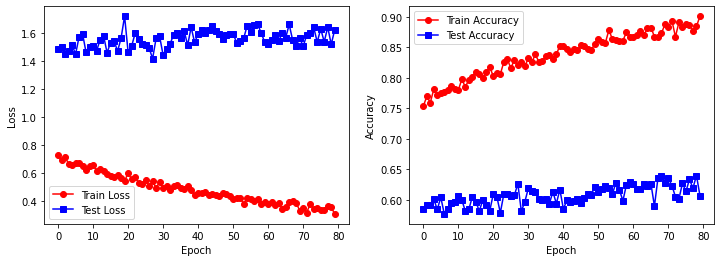

In [ ]:
# 绘制图像
plt.figure(figsize=(12, 4))
# 绘制 Loss 图像
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_all, "ro-", label="Train Loss")
plt.plot(range(epochs), test_loss_all, "bs-", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# 绘制 Accuracy 图像
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_all, "ro-", label="Train Accuracy")
plt.plot(range(epochs), test_acc_all, "bs-", label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
# 显示图像
plt.show()